# Import Dependencies

In [1]:
# Check system install
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True if GPU is detected

# General Imports
import numpy as np
import pandas as pd
import random
from tqdm import tqdm 
from torch.optim import Adam, SGD
import monai
import matplotlib.pyplot as plt
from matplotlib import patches
from torch.utils.data import DataLoader
from concurrent.futures import ThreadPoolExecutor
import torch.nn.functional as F
from monai.losses import DiceLoss


# Class Imports
# Reload modules so classes are reloaded every time
import importlib
import image_mask_dataset
import model_evaluator

from image_mask_dataset import ImageMaskDataset
from model_evaluator import ModelEvaluator




# MedSAM
from transformers import SamModel, SamProcessor, SamConfig

from segment_anything import sam_model_registry


from MedSAM.utils.demo import BboxPromptDemo



c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


2.6.0+cu126
True


## Gather data for each split

In [2]:
importlib.reload(image_mask_dataset)

# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

# Create dataset objects for each split
dataset_path = "Datasets/Dental project.v19i.coco-1"

test_dataset = ImageMaskDataset(dataset_path, "test", processor)

train_dataset = ImageMaskDataset(dataset_path, "train", processor)
valid_dataset = ImageMaskDataset(dataset_path, "valid", processor)



test_dataset[0]["pixel_values"].shape

# Test using a random image
# test_dataset.show_image_mask(random.randint(0,len(test_dataset)-1))
# train_dataset.show_image_mask(random.randint(0,len(train_dataset)-1))
# valid_dataset.show_image_mask(random.randint(0,len(valid_dataset)-1))



100%|██████████| 157/157 [00:00<00:00, 5775.76it/s]


(640, 640, 3)

# Base Model Evaluation

### Initialise MedSAM Model

In [4]:
MedSAM_checkpoint = "Models/medsam_vit_b.pth"

medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_checkpoint)
medsam_model = medsam_model.to("cuda")

medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


### Box Prompt Inference Demo

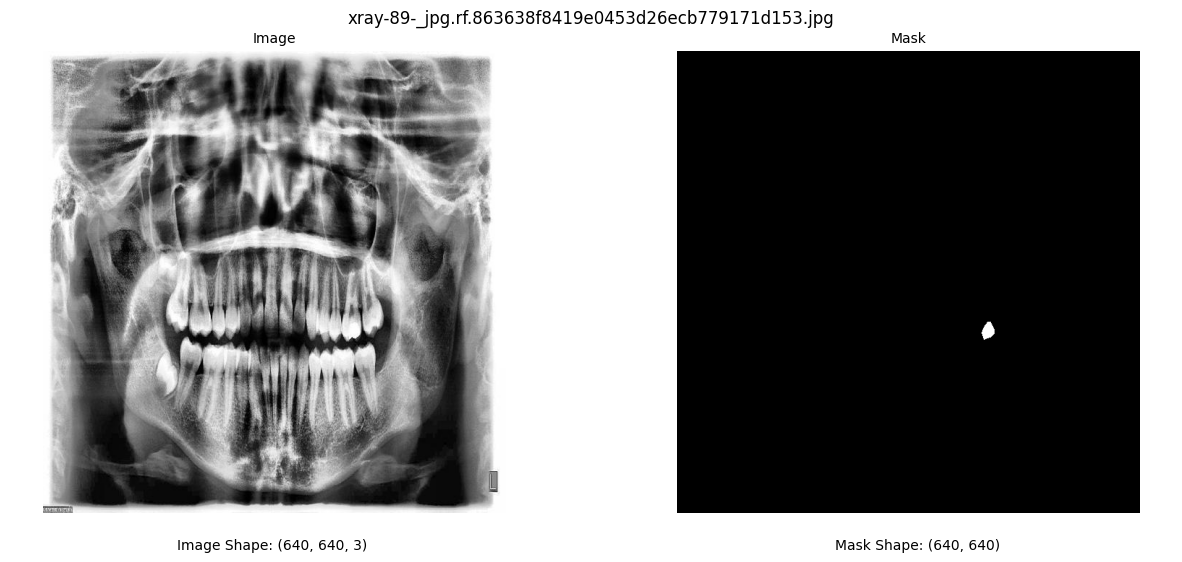

Button(description='clear', style=ButtonStyle())

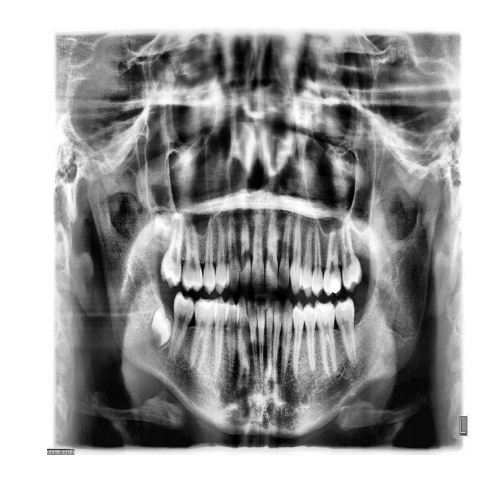

Button(description='save', style=ButtonStyle())

In [4]:
# Select random image
image_idx = random.randint(0, len(test_dataset)-1)
image = test_dataset.image_mask_pairs[image_idx][0]

# Display image
%matplotlib inline
test_dataset.show_image_mask(image_idx)

# Segment image
%matplotlib widget
bbox_prompt_demo = BboxPromptDemo(medsam_model)
bbox_prompt_demo.show(image)


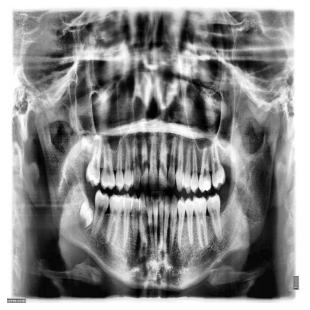

In [ ]:
%matplotlib inline

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:348: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box_1024 = torch.tensor(bounding_boxes, dtype=torch.float32, device="cuda")  # (5, 4)


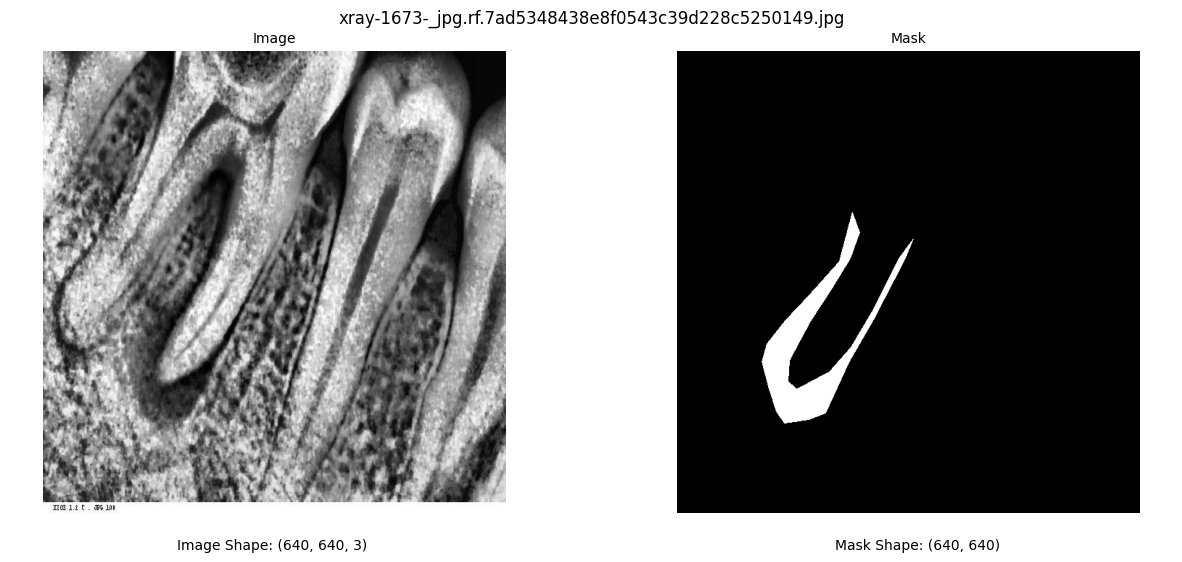

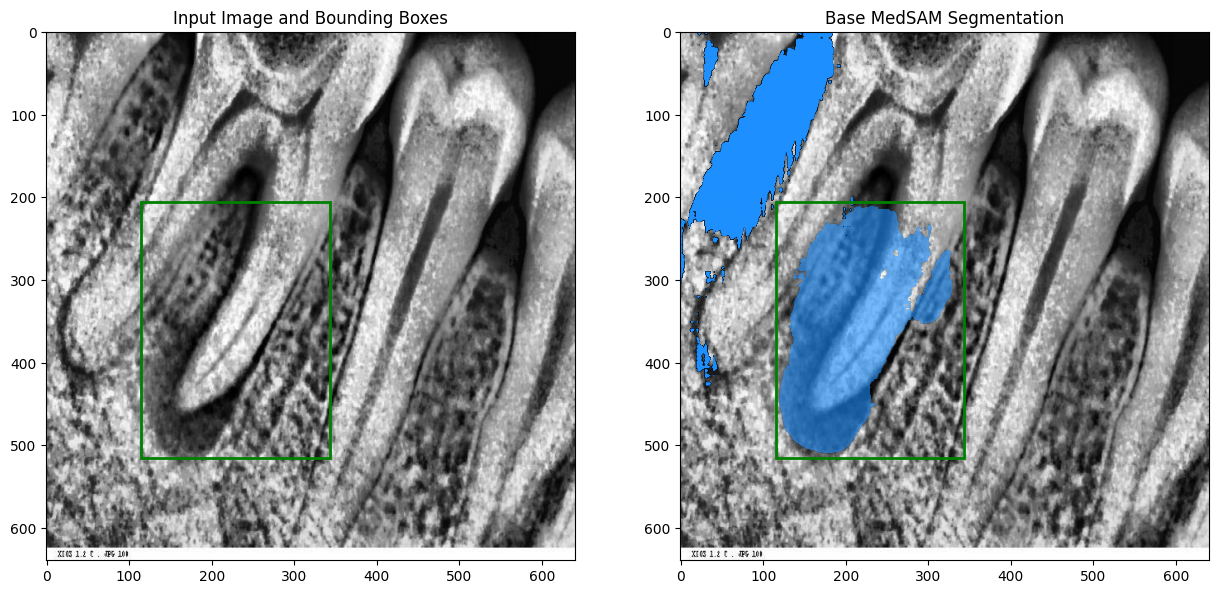

In [ ]:

importlib.reload(model_evaluator)
evaluator = ModelEvaluator(medsam_model, processor, test_dataset)


%matplotlib inline

# Get correct preprocessing
test_dataset.return_as_medsam = True
test_dataset.resize_mask = False

# Load random image
image_idx = random.randint(0, len(test_dataset)-1)


# Get tensors
img_np, box_np, gt_masks, bounding_boxes = test_dataset[image_idx].values()

# Get original image
test_dataset.return_as_medsam = False
img_original = test_dataset[image_idx]["pixel_values"]
W, H, _ = img_original.shape

# Show image
test_dataset.show_image_mask(image_idx)

# image embedding
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_np)


# Run inference for all boxes in a batch
with torch.no_grad():
    seg_masks = evaluator.medsam_inference(image_embedding, box_np, H, W)  # List of 5 masks

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))


if len(seg_masks.shape) == 2:
    seg_masks = [seg_masks]


# Original image with bounding boxes
ax[0].imshow(img_original)
for box in bounding_boxes:
    show_box(box, ax[0])
ax[0].set_title("Input Image and Bounding Boxes")

# Image with segmentation masks
ax[1].imshow(img_original)
for box, mask in zip(bounding_boxes, seg_masks):  # Iterate over all boxes and their masks
    show_mask(mask, ax[1]) # random_colour = True
    show_box(box, ax[1])
ax[1].set_title("Base MedSAM Segmentation")

plt.show()

### MedSAM Base Model Evaluation

In [9]:
results = evaluator.evaluate_medsam_model()
evaluator.print_results()

Evaluating MedSAM:   0%|          | 0/82 [00:00<?, ?it/s]d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\model_evaluator.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth_mask_tensor = torch.tensor(ground_truth_mask_tensor, dtype=torch.float32).unsqueeze(0).to("cuda")
Evaluating MedSAM:  12%|█▏        | 10/82 [00:27<03:14,  2.70s/it]


KeyboardInterrupt: 

# Fine-tuning MedSAM

### Set and verify dataloaders

d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box_1024 = torch.tensor(bounding_boxes, dtype=torch.float32, device="cpu")  # (5, 4)
c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  object_masks = [torch.tenso

pixel_values              Shape: torch.Size([3, 1024, 1024])    Dtype: torch.float32
original_sizes            Shape: torch.Size([2])                Dtype: torch.int64
reshaped_input_sizes      Shape: torch.Size([2])                Dtype: torch.int64
input_boxes               Shape: torch.Size([25, 4])            Dtype: torch.float64
ground_truth_mask         Shape: torch.Size([25, 256, 256])     Dtype: torch.float32


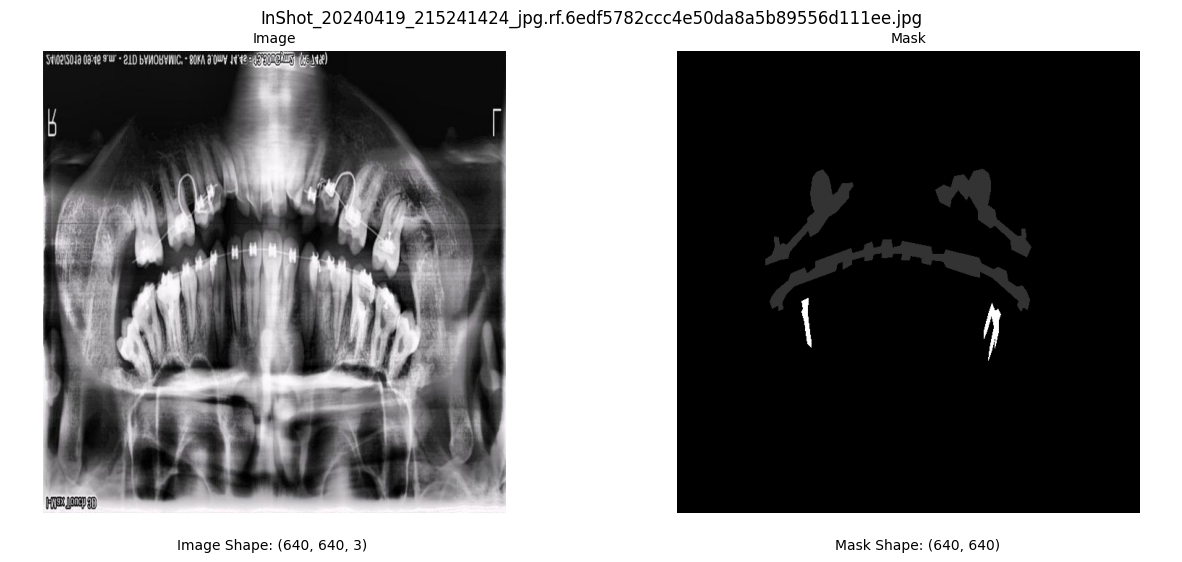

In [3]:
# Ensure images are returned as preprocessed tensors of the right size
test_dataset.return_as_sam  = True
train_dataset.return_as_sam = True
valid_dataset.return_as_sam = True

test_dataset.resize_mask  = True
train_dataset.resize_mask = True
valid_dataset.resize_mask = True

test_dataset.return_individual_objects = True
train_dataset.return_individual_objects = True
valid_dataset.return_individual_objects = True



# Veryify item sizes
example = train_dataset[0]

for k,v in example.items():
  print(f"{k:<25} Shape: {str(v.shape):<30} Dtype: {v.dtype}")

train_dataset.show_image_mask(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


pixel_values              Shape: torch.Size([2, 3, 1024, 1024]) Dtype: torch.float32
original_sizes            Shape: torch.Size([2, 2])             Dtype: torch.int64
reshaped_input_sizes      Shape: torch.Size([2, 2])             Dtype: torch.int64
input_boxes               Shape: torch.Size([2, 25, 4])         Dtype: torch.float64
ground_truth_mask         Shape: torch.Size([2, 25, 256, 256])  Dtype: torch.float32
Example Input:

(1024, 1024, 3)


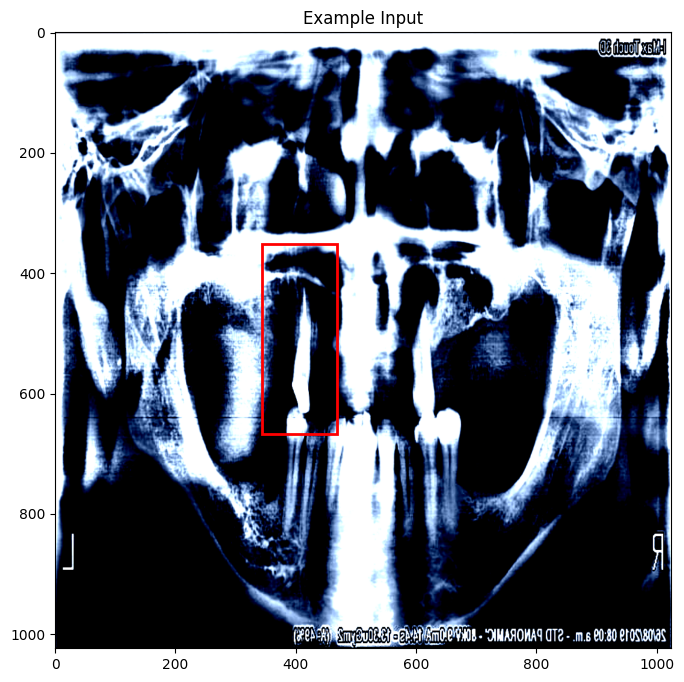

In [4]:
# Set up dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_dataloader = DataLoader(test_dataset,  batch_size=2, shuffle=False)



# Verify batch item sizes
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(f"{k:<25} Shape: {str(v.shape):<30} Dtype: {v.dtype}")




print("Example Input:\n")

# Get image from batch
image = batch["pixel_values"][0].detach().cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC format

print(image.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)  # Show the image

# Plot predicted boxes
for box in batch["input_boxes"][0]:
    rect = patches.Rectangle(
        (box[0], box[1]),  # x, y (top-left corner)
        box[2] - box[0],  # width
        box[3] - box[1],  # height
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        label='Predicted Box'
    )
    ax.add_patch(rect)


ax.set_title(f"Example Input")
plt.show()



## Fine-Tuning Hugging Face SamProcessor (MedSAM)

In [5]:
# Remove previous models from memory
medsam_model = None
del medsam_model
torch.cuda.empty_cache()

# load the pretrained weights for finetuning
medsam_model = SamModel.from_pretrained("flaviagiammarino/medsam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in medsam_model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

  
device = "cuda"
medsam_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [6]:
# Set optimisers and loss functions (These will be used for hyperparameter tuning later)


# Initialize the optimizer and the loss function (May need to play with lower learning rates to avoid changing base model too much)
adam_optimizer = Adam(medsam_model.mask_decoder.parameters(), lr=0.00001, weight_decay=0)

sgd_optimizer  = SGD(medsam_model.mask_decoder.parameters(), lr=0.01, momentum=0.9)


# Define the DiceCELoss
dice_ce_loss = monai.losses.DiceCELoss(
    sigmoid=True,            # sigmoid activation
    squared_pred=True,       # square predictions for  dice calculation (peanalises false positives)
    reduction='mean'         # how losses are aggregated (mean, sum, or none)
)


tversky_loss = monai.losses.TverskyLoss(
    alpha=0.7,              # false positives
    beta=0.3,               # false negatives
    reduction='mean',       # how losses are aggregated (mean, sum, or none)
)


# Maybe also try focal or dicefocal loss?


In [ ]:
from statistics import mean
from matplotlib import patches
from torch import nn
from torch.nn.functional import threshold, normalize




#Training loop
num_epochs = 1

medsam_model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

        

        # print(batch.keys())
      
        

        # forward pass
        outputs = medsam_model(pixel_values=batch["pixel_values"].to(device),
                        #input_masks=batch["labels"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

       

        # Get predicted masks and ground truth masks
        predicted_masks = outputs.pred_masks.squeeze(2)  # Remove extra singleton dimension from predicted masks (shape: [2, 20, 256, 256])
        ground_truth_masks = batch["ground_truth_mask"].float().to(device).squeeze(1)  # Remove extra singleton dimension from ground truth (shape: [2, 20, 256, 256])

        # Ensure the predicted and ground truth masks have the same shape
        # print(predicted_masks.shape)
        # print(ground_truth_masks.shape)

        # Calculate loss using defined loss function
        loss = dice_ce_loss(predicted_masks, ground_truth_masks)


        # backward pass
        adam_optimizer.zero_grad()
        loss.backward()

        # optimize
        adam_optimizer.step()
        epoch_losses.append(loss.item())





        # NOTE: sigmoid and softmax have the same output range here indicating that the SAM and MedSAM models only predict one class by default. This might 
        # Calculate the max and min values for both predicted and ground truth masks
        # pred_min_value = F.softmax(predicted_masks).min().item()
        # pred_max_value = F.softmax(predicted_masks).max().item()
        # gt_min_value = ground_truth_masks.min().item()
        # gt_max_value = ground_truth_masks.max().item()

        # # Print the min and max values for both predicted and ground truth masks
        # print(f"Predicted Mask - Min Value: {pred_min_value}, Max Value: {pred_max_value}")
        # print(f"Ground Truth Mask - Min Value: {gt_min_value}, Max Value: {gt_max_value}")







    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
     

# Save the model's state dictionary to a file
torch.save(medsam_model.state_dict(), "Models/medsam_vit_b_object_masks.pth")
     


  0%|          | 0/850 [00:00<?, ?it/s]d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  box_1024 = torch.tensor(bounding_boxes, dtype=torch.float32, device="cpu")  # (5, 4)
c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
d:\Documents\Uni Work\Automated Dental Segmentation\Automated-Dental-Segmentation\image_mask_dataset.py:304: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

Predicted Mask - Min Value: 1.106081562908675e-15, Max Value: 1.0
Ground Truth Mask - Min Value: 0.0, Max Value: 1.0


  0%|          | 2/850 [00:45<5:06:56, 21.72s/it]

Predicted Mask - Min Value: 2.6460176034785145e-17, Max Value: 1.0
Ground Truth Mask - Min Value: 0.0, Max Value: 1.0


  0%|          | 3/850 [01:02<4:37:14, 19.64s/it]

Predicted Mask - Min Value: 1.544461082479974e-16, Max Value: 1.0
Ground Truth Mask - Min Value: 0.0, Max Value: 1.0


  0%|          | 4/850 [01:18<4:16:16, 18.18s/it]

Predicted Mask - Min Value: 3.2336689783382753e-16, Max Value: 1.0
Ground Truth Mask - Min Value: 0.0, Max Value: 1.0


  0%|          | 4/850 [01:33<5:29:17, 23.35s/it]


KeyboardInterrupt: 

# Fine-Tuned Model Evaluation

### Load Model

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("flaviagiammarino/medsam-vit-base")
processor = SamProcessor.from_pretrained("flaviagiammarino/medsam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("Models\medsam_vit_b_object_masks.pth")) 

# set the device to cuda
device = "cuda"
my_model.to(device)
     

KeyboardInterrupt: 

### Box Prompt Inference Demo

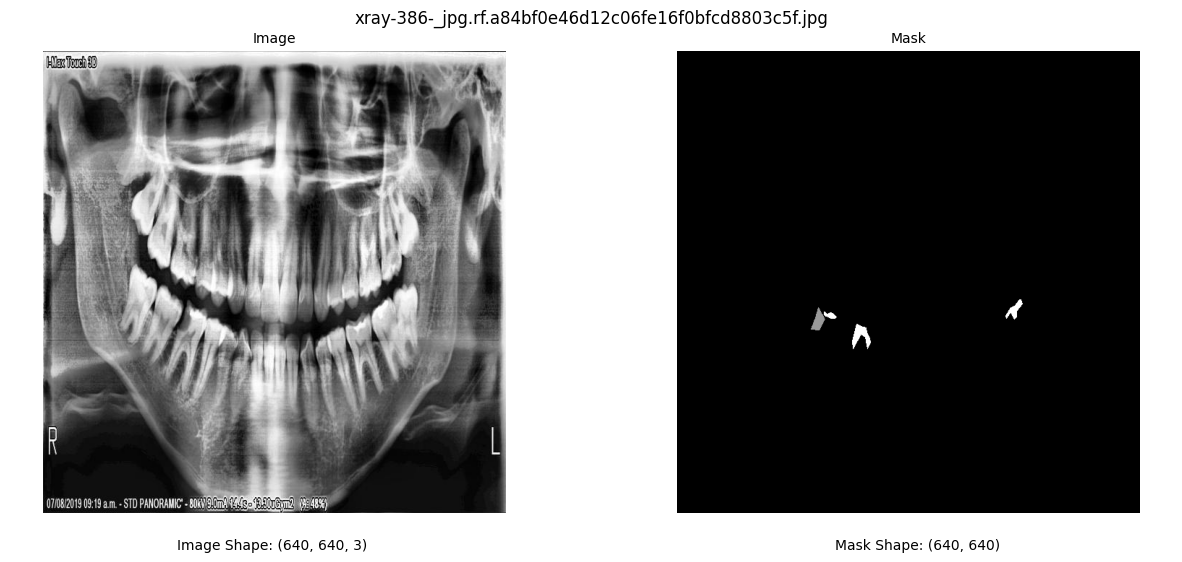

AttributeError: 'SamModel' object has no attribute 'image_encoder'

In [29]:
# Select random image
image_idx = random.randint(0, len(test_dataset)-1)
image = test_dataset.image_mask_pairs[image_idx][0]

# Display image
%matplotlib inline
test_dataset.show_image_mask(image_idx)

# Segment image
%matplotlib widget
bbox_prompt_demo = BboxPromptDemo(my_model)
bbox_prompt_demo.show(image)


### Test Inference

In [ ]:
%matplotlib inline

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [ ]:

importlib.reload(model_evaluator)
evaluator = ModelEvaluator(my_model, processor, test_dataset)


%matplotlib inline

# Get correct preprocessing
test_dataset.return_as_medsam = True
test_dataset.resize_mask = False

# Load random image
#image_idx = random.randint(0, len(test_dataset)-1)

image_idx = 33

# Get tensors
img_np, box_np, gt_masks, bounding_boxes = test_dataset[image_idx].values()

# Get original image
test_dataset.return_as_medsam = False
img_original = test_dataset[image_idx]["pixel_values"]
W, H, _ = img_original.shape

# Show image
test_dataset.show_image_mask(image_idx)

# image embedding
with torch.no_grad():
    image_embedding = my_model.image_encoder(img_np)


# Run inference for all boxes in a batch
with torch.no_grad():
    seg_masks = evaluator.medsam_inference(image_embedding, box_np, H, W)  # List of 5 masks

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 7))


if len(seg_masks.shape) == 2:
    seg_masks = [seg_masks]


# Original image with bounding boxes
ax[0].imshow(img_original)
for box in bounding_boxes:
    show_box(box, ax[0])
ax[0].set_title("Input Image and Bounding Boxes")

# Image with segmentation masks
ax[1].imshow(img_original)
for box, mask in zip(bounding_boxes, seg_masks):  # Iterate over all boxes and their masks
    show_mask(mask, ax[1]) # random_colour = True
    show_box(box, ax[1])
ax[1].set_title("Base MedSAM Segmentation")

plt.show()

In [ ]:
# Verify batch item sizes
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(f"{k:<25} Shape: {str(v.shape):<30} Dtype: {v.dtype}")




print("Example Input:\n")

# Get image from batch
image = batch["pixel_values"][0].detach().cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC format

print(image.shape)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)  # Show the image

# Plot predicted boxes
for box in batch["input_boxes"][0]:
    rect = patches.Rectangle(
        (box[0], box[1]),  # x, y (top-left corner)
        box[2] - box[0],  # width
        box[3] - box[1],  # height
        linewidth=2,
        edgecolor='red',
        facecolor='none',
        label='Predicted Box'
    )
    ax.add_patch(rect)

    


ax.set_title(f"Test Inference")
plt.show()



### MedSAM Fine-Tuned Model Evaluation

In [ ]:
# Evaluator defined above !!!
results = evaluator.evaluate_medsam_model()
evaluator.print_results()